In [2]:
using_colab = False

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [5]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

In [6]:
image = cv2.imread('images/A23.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

scale_percent = 30 # percent of original size
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
print('Resized Dimensions : ',image.shape)

Resized Dimensions :  (550, 979, 3)


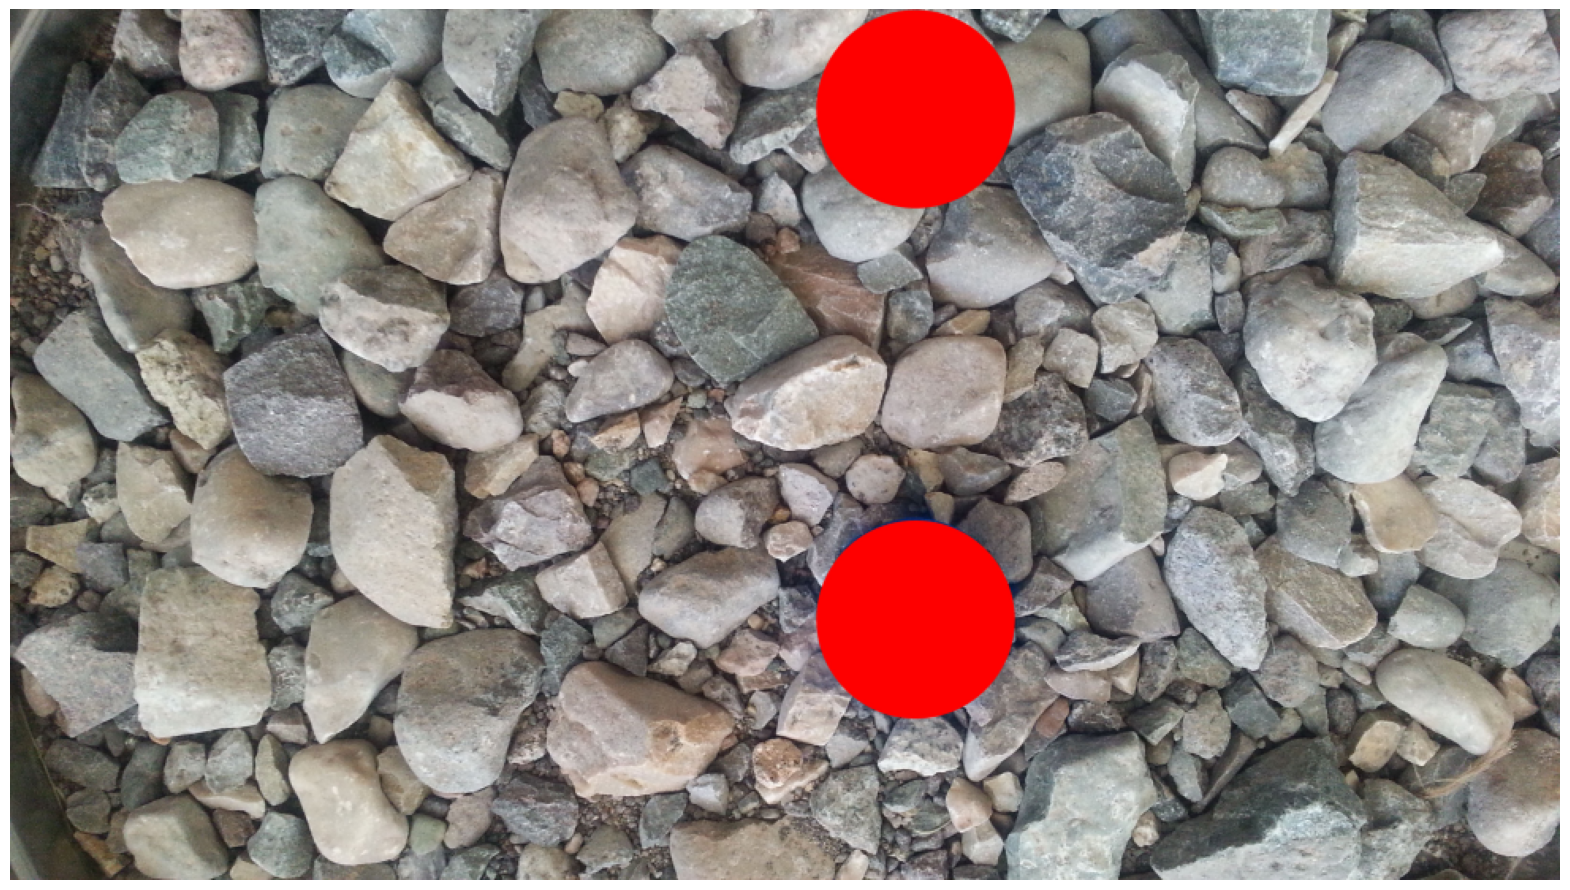

In [7]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [8]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "models/sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)
predictor = SamPredictor(sam)

In [9]:
masks = mask_generator.generate(image)

In [10]:
print(len(masks))
print(masks[0].keys())

276
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [19]:
masks[0]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 12188,
 'bbox': [510, 322, 124, 125],
 'predicted_iou': 1.0167523622512817,
 'point_coords': [[535.390625, 335.15625]],
 'stability_score': 0.980178713798523,
 'crop_box': [0, 0, 979, 550]}

In [63]:
import pandas as pd
l = [(mask['area'], mask['stability_score']) for mask in masks]
l = np.transpose(np.array(l))
pd.DataFrame({'area':l[0], 'score':l[1]}).describe()



area       score
count    276.000000  276.000000
mean    1985.750000    0.972669
std     2022.308492    0.009772
min      116.000000    0.950000
25%      593.250000    0.965969
50%     1105.000000    0.973758
75%     2991.000000    0.980225
max    12255.000000    0.991667

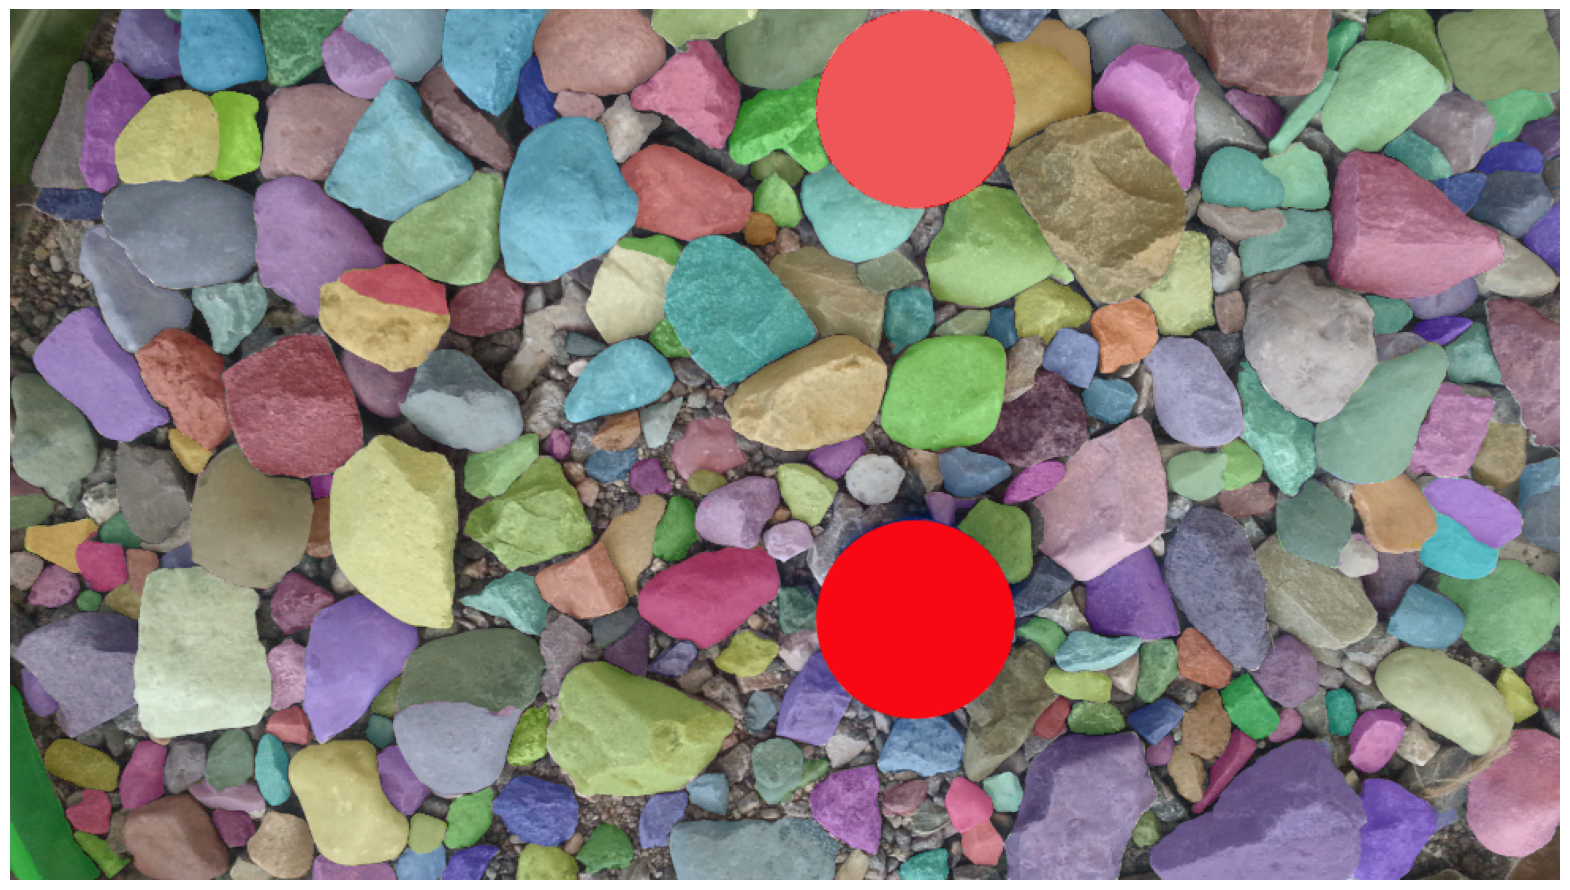

In [10]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

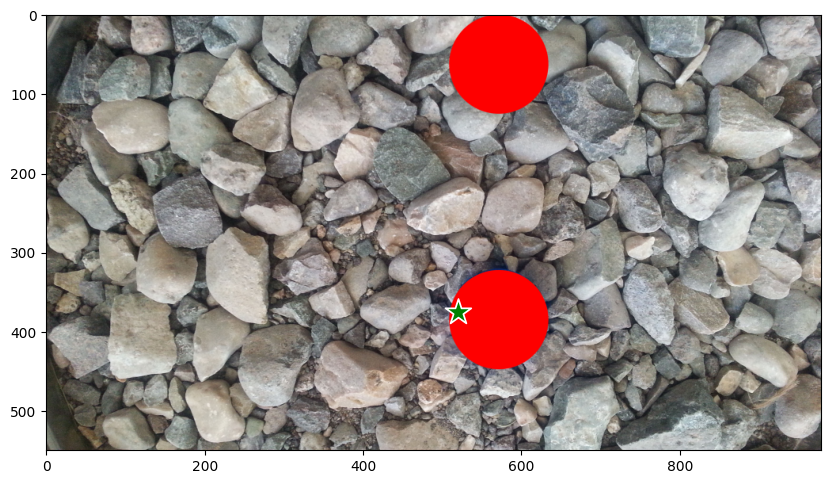

In [15]:
predictor.set_image(image)

input_point = np.array([[520, 375]])
input_label = np.array([1])
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [16]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [17]:
masks.shape

(3, 550, 979)

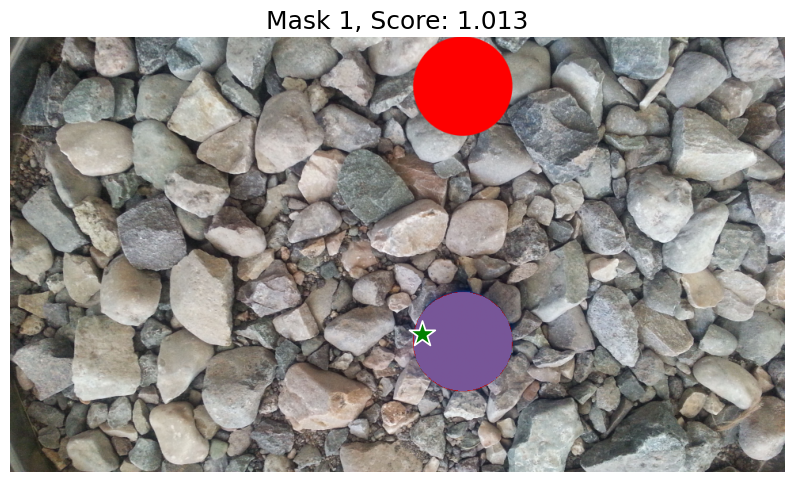

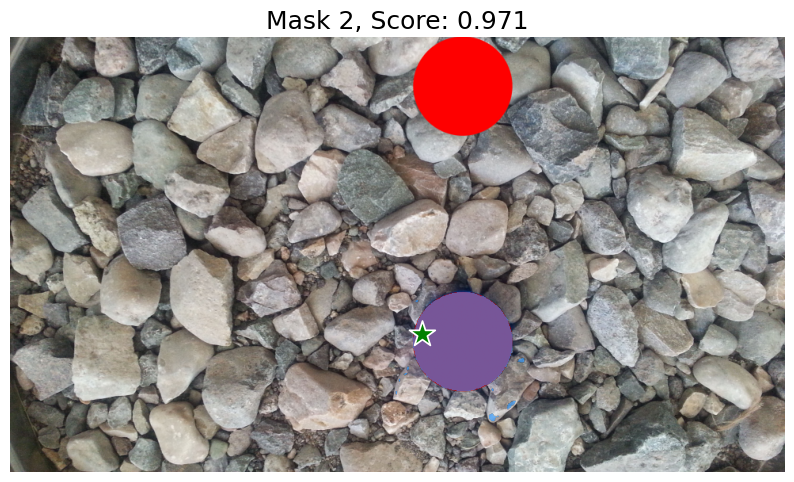

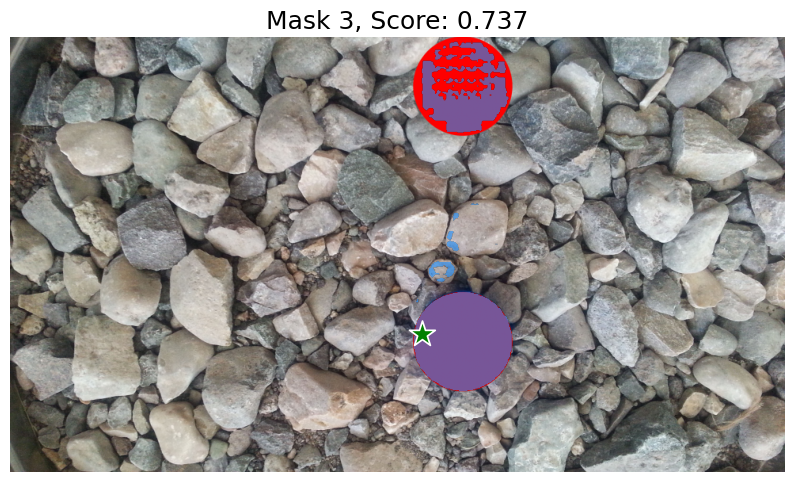

In [18]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  